In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

In [2]:
mesh_3d, models = Mesh.TensorMesh.read_vtk("./data/models.vtr")
active_inds = models['actv'].astype(bool)
resistivity = models['resistivity']
resistivity[~active_inds] = np.nan
n = resistivity[active_inds.astype(bool)].size
mesh_2d = Mesh.TensorMesh([mesh_3d.hx, mesh_3d.hy], x0=mesh_3d.x0[:2])

In [3]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt("./data/waveform_hm_312.txt")
waveform_lm_312 = np.loadtxt("./data/waveform_lm_312.txt")
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt("./data/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [4]:
df_skytem = pd.read_csv("./data/slo-skytem-312-data.csv")
hm_header = ['HM_{0}'.format(ii+1) for ii in range(times_hm_312.size)]
lm_header = ['LM_{0}'.format(ii+1) for ii in range(times_lm_312.size)]
line= df_skytem.Line.values
data_hm = df_skytem[hm_header].values
data_lm = df_skytem[lm_header].values

In [7]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver

In [8]:
hz = np.array([ 2.999232 ,  3.1991808,  3.3991296,  3.6990528,  3.8990016,
        4.1989248,  4.498848 ,  4.7987712,  5.0986944,  5.498592 ,
        5.8984896,  6.2983872,  6.6982848,  7.1981568,  7.6980288,
        8.1979008,  8.7977472,  9.3975936, 10.0974144, 10.7972352,
       11.497056 , 12.2968512, 13.1966208, 14.0963904, 14.99616  ,
       16.0958784, 17.1955968, 18.3952896, 19.6949568, 21.0945984,
       22.49424  , 24.0938304, 25.7933952, 27.49296  , 29.492448 ,
       31.491936 , 33.6913728, 35.990784 , 38.490144 ])

In [9]:
n_sounding = df_skytem.shape[0]
mesh = get_2d_mesh(n_sounding, hz)
dem = df_skytem.Elevation.values[:]
height = df_skytem['Src Height'].values[:]
xy = df_skytem[['X', 'Y']].values
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]

time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    time.append(times_hm_312)
    time_dual_moment.append(times_lm_312)
    time_input_currents.append(time_input_currents_hm_312)
    input_currents.append(input_currents_hm_312)
    time_input_currents_dual_moment.append(time_input_currents_lm_312)
    input_currents_dual_moment.append(input_currents_lm_312)        

In [10]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=5,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 5


In [16]:
dobs = -np.hstack((data_hm, data_lm)).flatten()

In [17]:
time = np.r_[times_hm_312, times_lm_312]

In [18]:
DOBS = dobs.reshape((n_sounding, times_hm_312.size+times_lm_312.size))

In [19]:
area = 342.

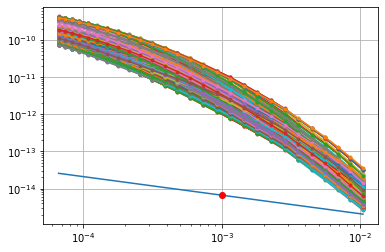

In [23]:
n_turns = 12
tx_currents = 110.10
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_hm = times_hm_312**-0.5 * c
plt.loglog(times_hm_312, times_hm_312**-0.5 * c)
out = plt.loglog(times_hm_312, -DOBS[::10,:times_hm_312.size].T, '.-')
# plt.plot(times_hm_312, np.ones_like(times_hm_312) * 1e-14, 'k--')
plt.plot(t, v, 'ro')
plt.grid(True)

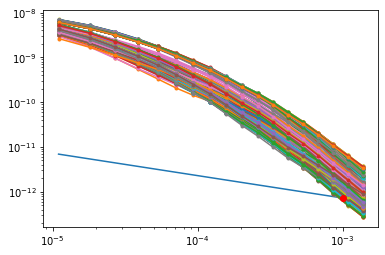

In [24]:
n_turns = 2
tx_currents = 6.04
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_lm = times_lm_312**-0.5 * c
plt.loglog(times_lm_312, times_lm_312**-0.5 * c)
out = plt.loglog(times_lm_312, -DOBS[::10,times_hm_312.size:].T, '.-')
plt.plot(t, v, 'ro')

In [25]:
noise_floor = np.hstack((np.tile(noise_hm, (n_sounding, 1)), np.tile(noise_lm, (n_sounding, 1)))) * np.random.randn(n_sounding, time.size)
floor = np.hstack((np.tile(noise_hm, (n_sounding, 1)), np.tile(noise_lm, (n_sounding, 1)))).flatten()
DOBS_noisy = DOBS + noise_floor

In [26]:
std = 0.03
uncert = abs(dobs)*std + floor
survey.dobs = dobs

In [36]:
m1 = np.load("./doi/m1.npy")
m2 = np.load("./doi/m2.npy")
mref1 = np.log(1./15.)
mref2 = np.log(1./30.)

In [239]:
def depth_of_investigation(m1, m2, mref1, mref2):
    doi_index = (m1-m2) / (mref1-mref2)
#     doi_index = np.clip(doi_index, 0, 1)
    return doi_index

In [304]:
def get_doi(doi_index, hz, n_sounding, doi_threshold=0.8, clip=None):
    depth = np.cumsum(hz)
    DOI_INDEX = doi_index.reshape((hz.size, n_sounding), order='F')
    doi = np.zeros(n_sounding) * np.nan
    for i_sounding in range(n_sounding):
        doi_index_tmp = DOI_INDEX[:,i_sounding]
        for i_layer in range(hz.size):            
            if doi_index_tmp[i_layer] > doi_threshold:
                doi[i_sounding] = depth[i_layer]
                break
    if clip is not None:
        doi = np.clip(doi, clip[0], clip[1])
    return doi

In [305]:
doi_index = depth_of_investigation(m1, m2, mref1, mref2)

In [306]:
doi_07 = get_doi(doi_index, hz, n_sounding, doi_threshold=0.7)
doi_08 = get_doi(doi_index, hz, n_sounding, doi_threshold=0.8)
doi_09 = get_doi(doi_index, hz, n_sounding, doi_threshold=0.9)

In [318]:
doi_03 = get_doi(doi_index, hz, n_sounding, doi_threshold=0.3, clip=(150, 350))

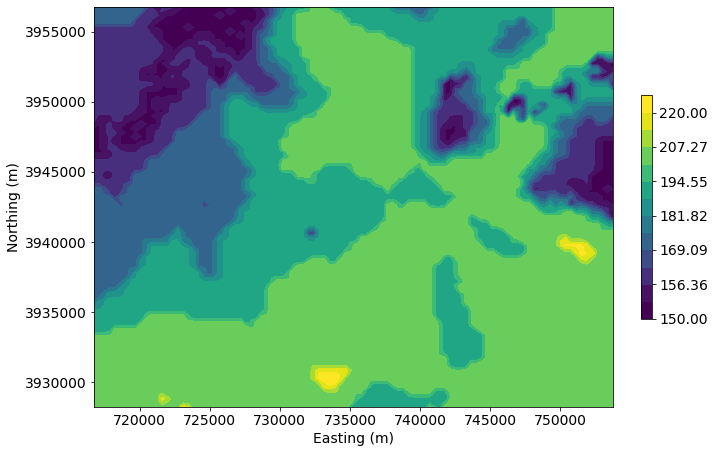

In [319]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
out = Utils.plot2Ddata(IO.topography[:,:2], doi_03, ncontour=10, scale='linear', ax=ax, clim=(150, 220))
# plt.plot(IO.topography[:,0], IO.topography[:,1], 'k.')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
cb = plt.colorbar(out[0], ax=ax, fraction=0.02)

In [264]:
import matplotlib 
matplotlib.rcParams['font.size'] = 14

In [255]:
Utils.plot2Ddata?

Text(0, 0.5, 'Northing (m)')

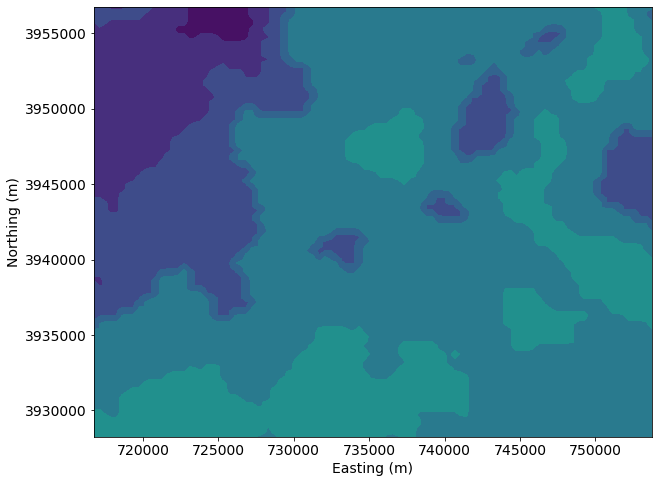

In [274]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
out = Utils.plot2Ddata(IO.topography[:,:2], doi_07, ncontour=10, scale='linear', ax=ax, clim=(200, 350))
# plt.plot(IO.topography[:,0], IO.topography[:,1], 'k.')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
# cb = plt.colorbar(out[0], ax=ax, fraction=0.02)

Text(0.5, 0, 'Easting (m)')

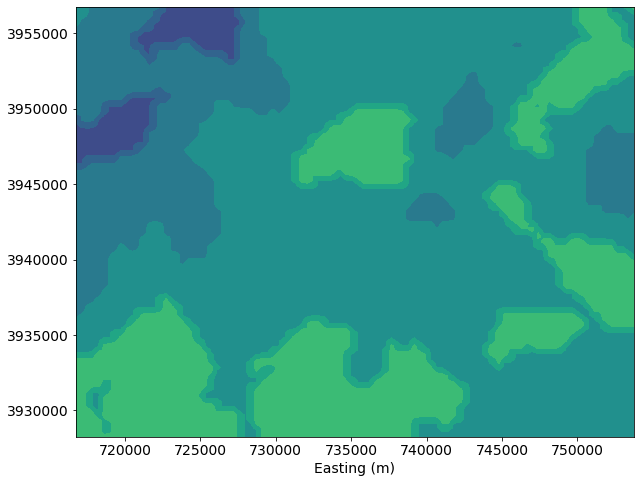

In [276]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
out = Utils.plot2Ddata(IO.topography[:,:2], doi_08, ncontour=10, scale='linear', ax=ax, clim=(200, 350))
# plt.plot(IO.topography[:,0], IO.topography[:,1], 'k.')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
# ax.set_ylabel("Northing (m)")
# cb = plt.colorbar(out[0], ax=ax, fraction=0.02)

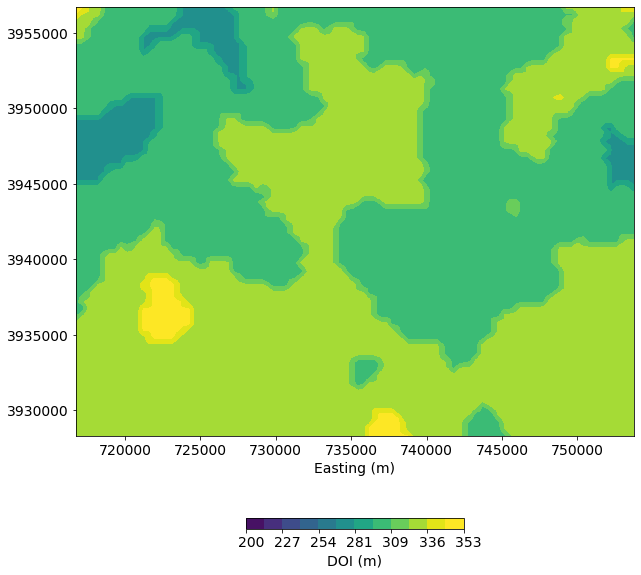

In [282]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
out = Utils.plot2Ddata(IO.topography[:,:2], doi_09, ncontour=10, scale='linear', ax=ax, clim=(200, 350))
# plt.plot(IO.topography[:,0], IO.topography[:,1], 'k.')
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
# ax.set_ylabel("Northing (m)")
cb = plt.colorbar(out[0], ax=ax, fraction=0.02, orientation='horizontal', format="%5i")
cb.set_label("DOI (m)")

In [190]:
import pandas as pd

In [268]:
doi_data = np.c_[IO.topography, doi_07, doi_08, doi_09]
df_doi = pd.DataFrame(data=doi_data, columns=["X", "Y", "Elevation", "DOI_07", "DOI_08", "DOI_09"])
df_doi.to_csv("./doi/doi_xyz.csv", index=False)

In [40]:
from scipy.interpolate import NearestNDInterpolator
f_int = NearestNDInterpolator(mesh_3d.gridCC, models['resistivity'])
xyz = IO.xyz.reshape((np.prod(IO.xyz.shape[:2]), IO.xyz.shape[2]))
tmp = f_int(xyz)
res_true= Utils.mkvc(tmp.reshape(IO.xyz.shape[:2]))

In [320]:
i_line = 14
# i_line = 40
ind_line = line == i_line
yc = np.unique(xy[ind_line,1])

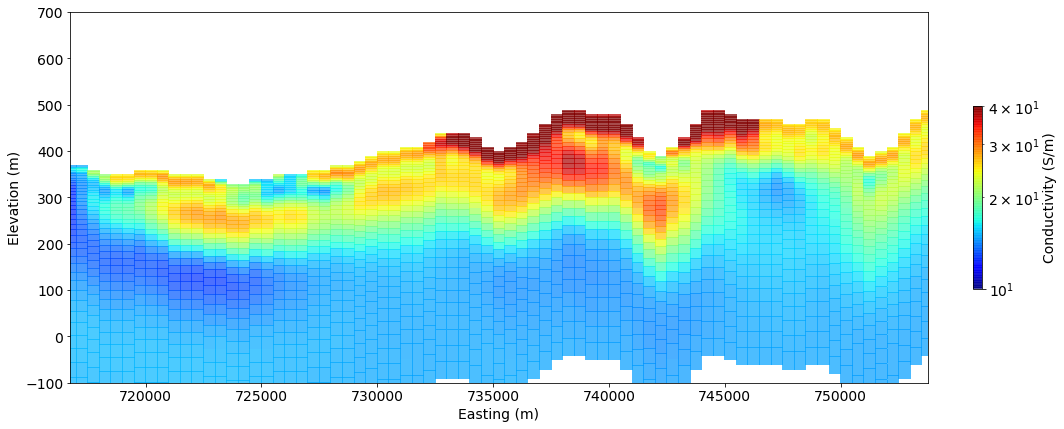

In [321]:
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=1./np.exp(Utils.mkvc(m1.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=line[::nskip]
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet', aspect=20, clim=(10, 40), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)

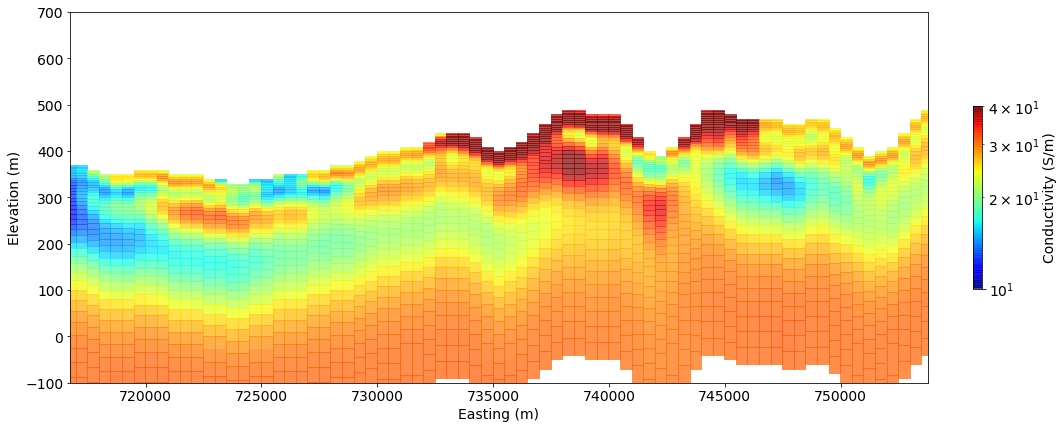

In [322]:
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=1./np.exp(Utils.mkvc(m2.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=line[::nskip]
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet', aspect=20, clim=(10, 40), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)

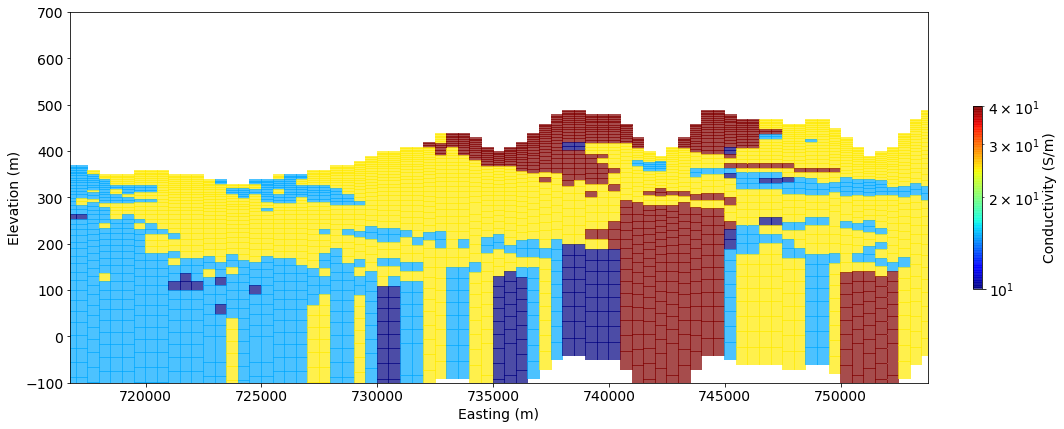

In [323]:
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=res_true,
    line=line[::nskip]
)
IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet', aspect=20, clim=(10, 40), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)

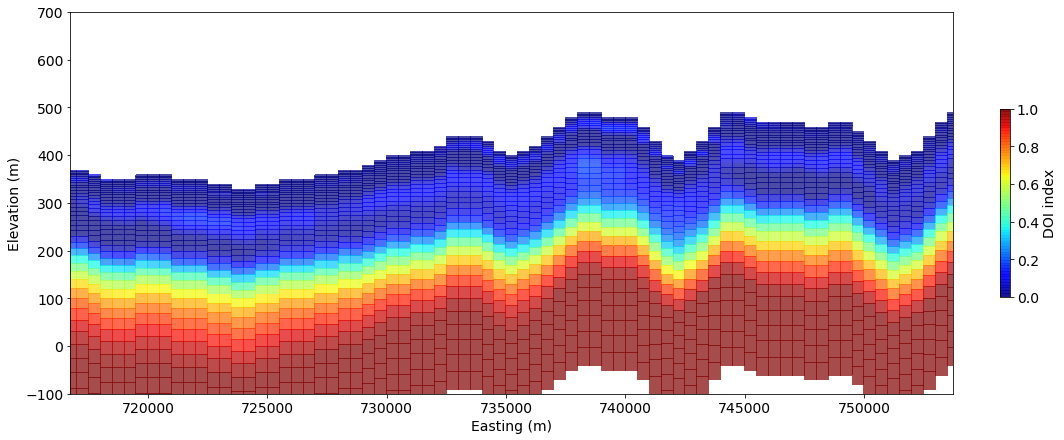

In [324]:
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=doi_index,
    line=line[::nskip]
)
out = IO.plot_section(line_direction='x', scale='linear', plot_type='pcolor', cmap='jet', aspect=20, clim=(0, 1), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)
cb = out[2]
cb.set_label("DOI index")

In [325]:
doi_index_nan = doi_index.copy()
doi_index_nan[doi_index>0.8] = np.nan

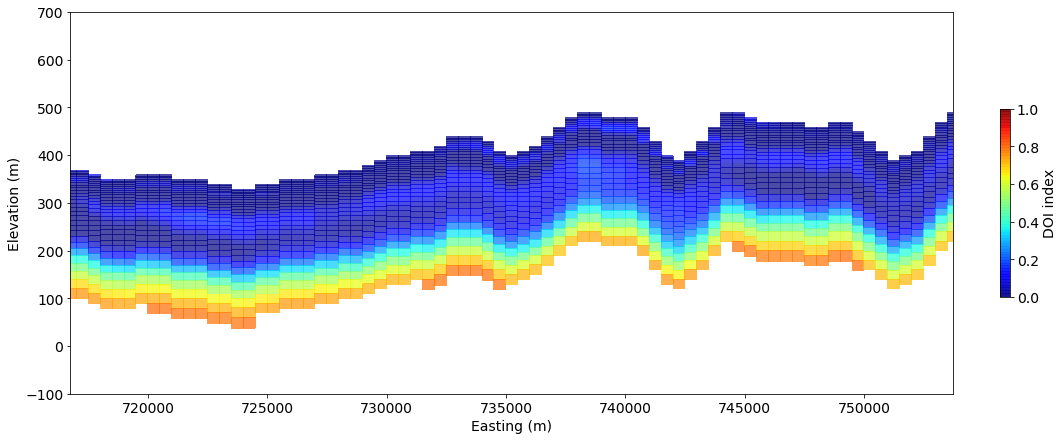

In [326]:
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=doi_index_nan,
    line=line[::nskip]
)
out = IO.plot_section(line_direction='x', scale='linear', plot_type='pcolor', cmap='jet', aspect=20, clim=(0, 1), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)
cb = out[2]
cb.set_label("DOI index")